# Netflix Stock Price Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('NFLX_data.csv')
df.sort_values('Date',inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-01-03,3.714286,3.824286,3.677143,3.801429,3.801429,16440900
1,2007-01-04,3.772857,3.828571,3.585714,3.621428,3.621428,15959300
2,2007-01-05,3.620000,3.620000,3.492857,3.544286,3.544286,15190700
3,2007-01-08,3.545714,3.555714,3.367143,3.404286,3.404286,18344900
4,2007-01-09,3.427143,3.440000,3.360000,3.427143,3.427143,10611300


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3418 entries, 0 to 3417
Data columns (total 7 columns):
Date         3418 non-null object
Open         3418 non-null float64
High         3418 non-null float64
Low          3418 non-null float64
Close        3418 non-null float64
Adj Close    3418 non-null float64
Volume       3418 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 213.6+ KB


No missing values found.

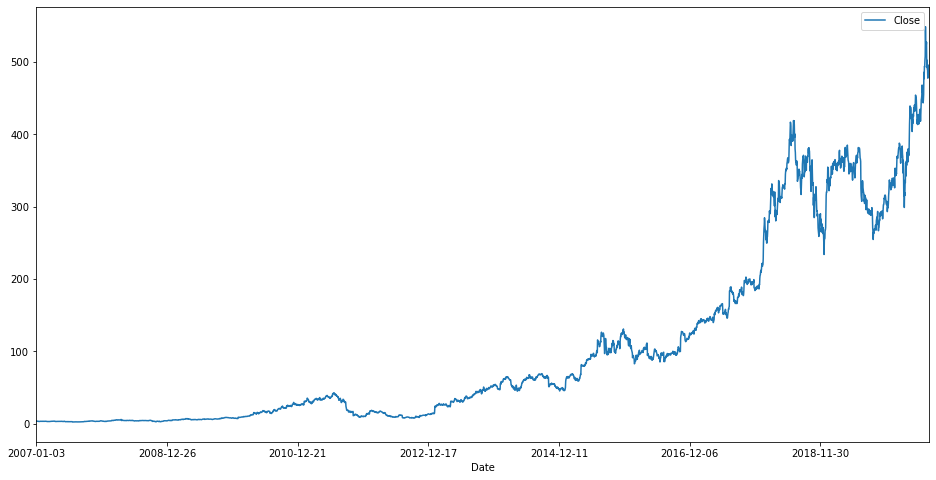

In [4]:
df.plot(x='Date',y='Close',figsize=(16,8))

In [5]:
close = df[['Close']]

In [6]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler(feature_range=(-1, 1))

In [7]:
close['Close'] = mm.fit_transform(close['Close'].values.reshape(-1,1))
close.head(3)

,Close
0,-0.994489
1,-0.995148
2,-0.995430


In [8]:
raw = close.as_matrix()
print('Shape: ',raw.shape)
print('')
print(raw[:5])

Shape:  (3418, 1)

[[-0.99448894]
 [-0.99514776]
 [-0.99543011]
 [-0.99594252]
 [-0.99585887]]


In [9]:
lookback = 30
data = []
for index in range(len(raw) - lookback): 
    data.append(raw[index: index + lookback]) 

In [10]:
data = np.array(data)
print(data.shape)
test_size = int(np.round(0.2*data.shape[0]))
train_size = data.shape[0] - (test_size)

(3388, 30, 1)


In [11]:
x_train = data[:train_size,:-1,:]
y_train = data[:train_size,-1,:]
    
x_test = data[train_size:,:-1]
y_test = data[train_size:,-1,:]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2710, 29, 1)
(2710, 1)
(678, 29, 1)
(678, 1)


In [12]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [13]:
n_steps = lookback - 1
batch_size = 1000
epochs = 120

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)


In [14]:
input_dim = 1
hidden_dim = 36
num_layers = 2
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim      
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    


In [15]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.007)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 36, num_layers=2, batch_first=True)
  (fc): Linear(in_features=36, out_features=1, bias=True)
)
10
torch.Size([144, 1])
torch.Size([144, 36])
torch.Size([144])
torch.Size([144])
torch.Size([144, 36])
torch.Size([144, 36])
torch.Size([144])
torch.Size([144])
torch.Size([1, 36])
torch.Size([1])


In [16]:
lis = np.zeros(epochs)
# Number of steps to unroll
seq_dim =lookback-1  
for t in range(epochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    lis[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  10 MSE:  0.09927669167518616
Epoch  20 MSE:  0.04487014189362526
Epoch  30 MSE:  0.03069787472486496
Epoch  40 MSE:  0.025434447452425957
Epoch  50 MSE:  0.02098577842116356
Epoch  60 MSE:  0.006395685486495495
Epoch  70 MSE:  0.0010665146401152015
Epoch  80 MSE:  0.00046448479406535625
Epoch  90 MSE:  0.0004086870467290282
Epoch  100 MSE:  0.00031363204470835626
Epoch  110 MSE:  0.0002742205106187612


In [17]:
prd = mm.inverse_transform(y_train_pred.detach().numpy())
org = mm.inverse_transform(y_train.detach().numpy())

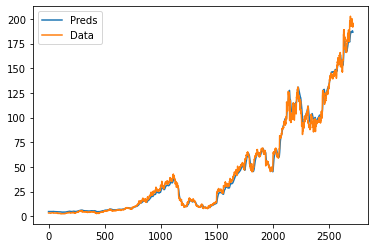

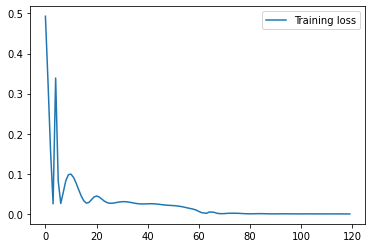

In [18]:
plt.plot(prd, label="Preds")
plt.plot(org, label="Data")
plt.legend()
plt.show()

plt.plot(lis, label="Training loss")
plt.legend()
plt.show()

In [19]:
np.shape(y_train_pred)

torch.Size([2710, 1])

In [20]:
import math
from sklearn.metrics import mean_squared_error
from math import sqrt

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = mm.inverse_transform(y_train_pred.detach().numpy())
y_train = mm.inverse_transform(y_train.detach().numpy())
y_test_pred = mm.inverse_transform(y_test_pred.detach().numpy())
y_test = mm.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.18 RMSE
Test Score: 86.50 RMSE


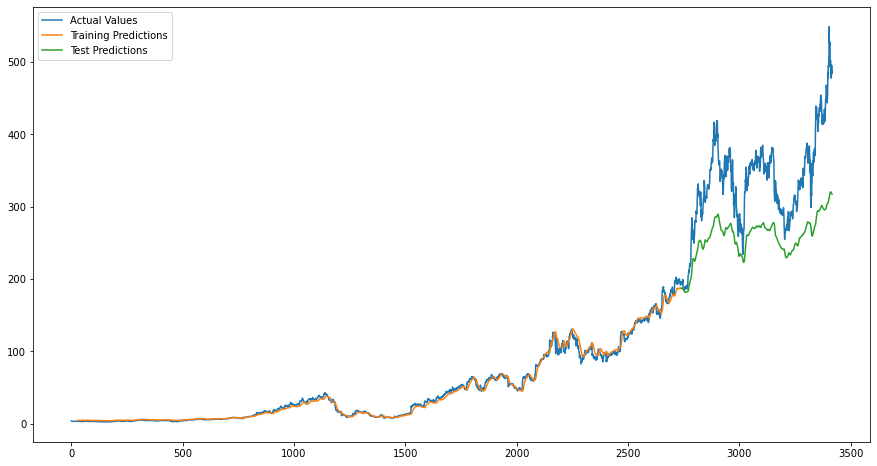

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(close)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(close)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(close)-1, :] = y_test_pred

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(mm.inverse_transform(close),label='Actual Values')
plt.plot(trainPredictPlot,label='Training Predictions')
plt.plot(testPredictPlot,label='Test Predictions')
plt.legend()
plt.show()